In [93]:
import random, importlib
import pickle
import xgb_functions as F
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
import numpy as np

data_store_path = "./feature_selection/DT_train_test_data"


In [73]:
def get_dt_xy(in_data_df, horizon_size=24, step_size=1):
    x = in_data_df.drop("Load", axis=1).iloc[:-horizon_size + 1]

    subseq_indexes = F.get_subsequence_indexes(in_data_df = in_data_df, window_size = 0 + horizon_size, step_size = step_size)
    lagged_x, y = F.get_xy_lagged(subseq_indexes=subseq_indexes, load_data=in_data_df["Load"].to_numpy(), 
                                  horizon_size=horizon_size, lag_size=0)

    return x, y

In [28]:
# Choose 5 random buses to test feature importances on

chosen_buses = random.sample(range(1, 29), 5)
chosen_buses.sort()
print(chosen_buses)

[5, 9, 10, 14, 20]


In [74]:
# DEFINE HYPERPARAMETERS

# Default hyperparameters
hyperparameters = {"n_estimators": 100, "max_depth": 3, "subsample": 1, 
                   "learning_rate": 0.1, "early_stopping_rounds": 10, "gamma": 0, "lambda": 1,
                   "early_stopping_rounds": None}


# n_estimators determines how many rounds of training (how many new trees can be made)
# early_stopping_rounds determines how many rounds of training can go before validation set score improves from its best score. Needs validation set 
#   to be included when training/fitting. If there is any number, the model with iteration that has best score on validation set will be used when 
#   predicting, even if training is not early stopped. In that case, it will be the same model as changing n_estimators to be the same as best validation iter


In [30]:
# GET ALL TRAINING AND TESTING X AND Y DATA


# Get train-test split for all busses
allbus_df = F.allbus_date_formatting(buses=chosen_buses)

In [75]:
# Get x,y train, test split for all busses

allbus_x_train, allbus_y_train, allbus_x_test, allbus_y_test = {},{},{},{}

for b in chosen_buses:
    x, y = get_dt_xy(allbus_df[b])

    split_date = "2018-10-16"

    original_timestep = (pd.Timestamp(split_date) - pd.Timestamp("2018-01-01 00:00:00")).total_seconds()/3600 # Get original timestep (hour) from split date
    split_timestep = int(original_timestep) # Split timestep in the new dataframe (starts at timestep lag_size)
    
    x_train = x.iloc[:split_timestep]
    y_train = y[:split_timestep]

    x_test, y_test = x.iloc[split_timestep:], y[split_timestep:]

    allbus_x_train[b], allbus_y_train[b], allbus_x_test[b], allbus_y_test[b] = \
    x_train, y_train, x_test, y_test



# Store the data in a file
# with open(f"{data_store_path}/allbus_train_test.pkl", "wb") as f:
#     pickle.dump((allbus_x_train, allbus_y_train, allbus_x_test, allbus_y_test, chosen_buses), f)

In [61]:
# TRAIN AND STORE THE MODELS FOR ALL BUSSES

trained_models, model_scores = F.get_models(models_datapath="./feature_selection/DT_MOR_1", hyperparameters=hyperparameters, score_function=mean_absolute_error, 
                                            buses=chosen_buses, allbus_x_train=allbus_x_train, allbus_y_train=allbus_y_train, 
                                            allbus_x_test=allbus_x_test, allbus_y_test=allbus_y_test)

[17:39:08] ======== Monitor (0): HostSketchContainer ========
[17:39:08] AllReduce: 0.000505s, 1 calls @ 505us

[17:39:08] MakeCuts: 0.001722s, 1 calls @ 1722us

[17:39:08] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 3
[17:39:08] ======== Monitor (0): Learner ========
[17:39:08] Configure: 0.006667s, 1 calls @ 6667us

[17:39:08] EvalOneIter: 0.001433s, 100 calls @ 1433us

[17:39:08] GetGradient: 0.001412s, 100 calls @ 1412us

[17:39:08] PredictRaw: 9.7e-05s, 100 calls @ 97us

[17:39:08] UpdateOneIter: 0.055031s, 100 calls @ 55031us

[17:39:08] ======== Monitor (0): GBTree ========
[17:39:08] BoostNewTrees: 0.045349s, 100 calls @ 45349us

[17:39:08] CommitModel: 4.8e-05s, 100 calls @ 48us

[17:39:08] ======== Monitor (0): HistUpdater ========
[17:39:08] BuildHistogram: 0.009655s, 200 calls @ 9655us

[17:39:08] EvaluateSplits: 0.010922s, 300 calls @ 10922us

[17:39:08] 

In [78]:
model_with_df, model_with_df_scores = F.get_model(allbus_x_train[5], allbus_y_train[5], "None", "None", allbus_x_test[5], allbus_y_test[5],
                                                  hyperparameters, mean_absolute_error)

[18:03:04] ======== Monitor (0): HostSketchContainer ========
[18:03:04] AllReduce: 0.00022s, 1 calls @ 220us

[18:03:04] MakeCuts: 0.001113s, 1 calls @ 1113us

[18:03:04] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 3
[18:03:04] ======== Monitor (0): Learner ========
[18:03:04] Configure: 0.001196s, 1 calls @ 1196us

[18:03:04] EvalOneIter: 0.000551s, 100 calls @ 551us

[18:03:04] GetGradient: 0.000829s, 100 calls @ 829us

[18:03:04] PredictRaw: 9.2e-05s, 100 calls @ 92us

[18:03:04] UpdateOneIter: 0.042953s, 100 calls @ 42953us

[18:03:04] ======== Monitor (0): GBTree ========
[18:03:04] BoostNewTrees: 0.039644s, 100 calls @ 39644us

[18:03:04] CommitModel: 5.4e-05s, 100 calls @ 54us

[18:03:04] ======== Monitor (0): HistUpdater ========
[18:03:04] BuildHistogram: 0.008306s, 200 calls @ 8306us

[18:03:04] EvaluateSplits: 0.009845s, 300 calls @ 9845us

[18:03:04] Init

In [171]:
def get_boxplot(chosen_buses, trained_models, feature_names):
    allbus_importances = []
    allbus_importance_names = []

    for bus in chosen_buses:
        allbus_importances.append(np.concatenate([trained_models[bus].estimators_[t].feature_importances_ for t in range(24)]))
        allbus_importance_names.append(np.concatenate([feature_names for _ in range(24)]))
    
    importance = np.concatenate(allbus_importances)
    ft_name = np.concatenate(allbus_importance_names)

    feature_importance_df = pd.DataFrame({"Feature": ft_name, "Importance": importance})

    sorting = feature_importance_df.groupby("Feature").mean().sort_values(by="Importance", ascending=False)

    plot = sns.boxplot(data=feature_importance_df, x="Feature", y="Importance", order=sorting.index).set_xticklabels(sorting.index, rotation=80)

    return feature_importance_df, sorting, plot


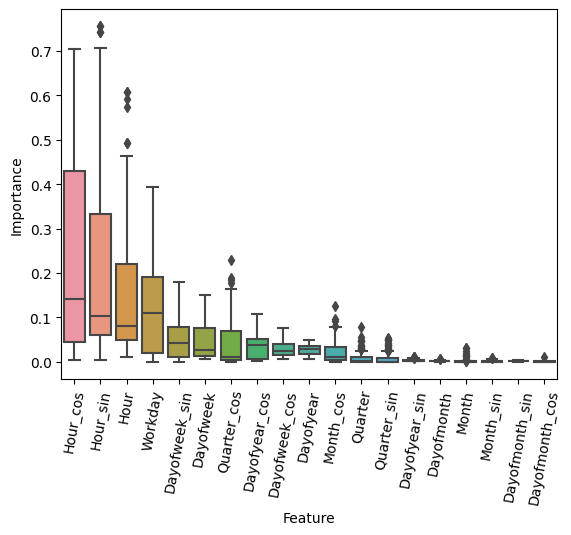

In [172]:
df, s, p = get_boxplot(chosen_buses, trained_models, feature_names=allbus_x_train[5].columns)